# Final Project - K-Means Algorithm
## CSPB 2820 -  Linear Algebra with Computer Science Applications
*Name*: Taylor Larrechea

Submit only this Jupyter notebook with the name format `Final_Project_<yourname>.ipynb`. Do not compress it using tar, rar, zip, etc. You must test this notebook in Jupyter Lab.
Your solutions to analysis questions should be written directly below the associated question. You can add a write-up markdown cell or an extra Python cell if it wasn't provided.

All the written code must be commented as shown in this link https://realpython.com/python-comments-guide/ 

Remember that you are encouraged to discuss the problems with your classmates and instructors, 
but *you must write all code and solutions on your own*, and list any people or sources consulted.

The goal of K-means is to partition the data into $k$ clusters such that the sum of intra-cluster variances is minimal.

In this problem, we'll be implementing K-means and evaluate it on the multi_blobs data shown below.

### Question 1 : What is the significance of K in K-Means algorithm ? [2 point]

### Answer:

The K value in the K-Means algorithm is the number of clusters that are going to be generated for the data set that is being clustered. The higher the value of K, the more clusters there will be for the data that is being clustered.

In [255]:
%matplotlib inline
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

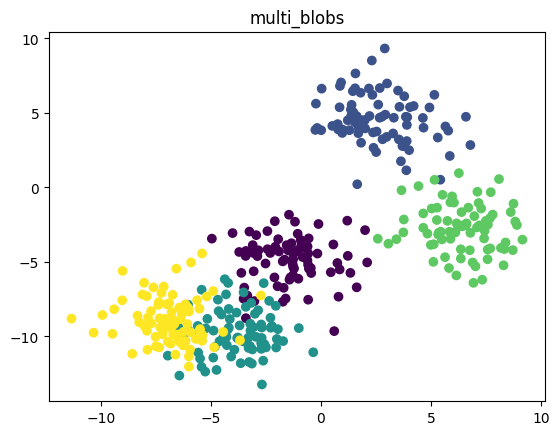

In [256]:
# Do not modify this cell
class DataBlobs:
    def __init__(self, centers, std=1.75):
        self.X, self.labels = make_blobs(n_samples=400, n_features=2, cluster_std=std, centers=centers,
                                         shuffle=False, random_state=5622)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.labels,
                                                                                test_size=0.3, random_state=5622)
multi_blobs = DataBlobs(centers=5, std=1.5)

plt.title("multi_blobs")
plt.scatter(multi_blobs.X[:, 0], multi_blobs.X[:, 1], c=multi_blobs.labels)
plt.show()


We will be using Euclidean distance as our variance measure, so for cluster $C_i = \{x_1,x_2,... x_{m_i}\}$, its intra-cluster variance $V(C_i)$ is defined as:

$$
V(C_i) = \sum_{j=1}^{m_i} ||x_j - \mu_i||^2
$$

where $\mu_i = \frac{1}{m} \sum_{i=1}^{m_i} x_i$. $\mu_i$ is called the centroid of cluster $C_i$.

So for $k$ clusters, K-means objective is:
$$
\min_{C_1,C_2\ldots C_k}\sum_{i=1}^{k}V(C_i) = \min_{C_1,C_2\ldots C_k} \sum_{i=1}^{k} \sum_{j=1}^{m_i} ||x_j - \mu_i||^2
$$

Each sample $x_i$ is assigned to the cluster of the closest centroid. Hence, finding the optimal partition $\{C_1,C_2...C_k\}$ that minimizes the objective is equivalent to finding the optimal centroids.

Unfortunately, there is no algorithm that reaches the global optima for K-means, but we'll be implementing the most famous heuristic for the problem: Llyod algorithm. It works as follows:

- Initialize the centroids with **unique** random samples (`initialize_centroids`), initial objective = $+\infty$
- Repeat until convergence:
    - Compute the distances matrix $D$ between samples and centroids (`compute_distances`)
    - Use $D$ to assign each sample to the cluster with the closest centroid (`computes_assignments`)
    - Update the centroids as centers of the new cluster assignments (`compute_centroids`)
    - Compute the new objective (`compute_objective`)
    - Stop if the improvement ratio of the objective is less than $\epsilon$

The improvement ratio equal to `|new_objective - previous_objective|/|previous_objective|`.


- **Implementation.1 (I.1) [8 points]** `initialize_centroids` : select K **distinct** samples from the matrix data `X` and use them as the initial centroids. Store these centroids in the class attribute `self.centroids` as an `np.array` of shape $k \times d$.
- **I.2 [8 points]** `compute_distances` : compute the distance of each sample $x_i$ to every centroid $c_j$ and return the result as a matrix `distances_matrix` of size $N \times k$ where `N` is the number of samples and `k` is the chosen number of clusters to be found. The cell `(i,k)` shall contain the euclidean distance between sample $x_i$ and centroid $m_k$.
- **I.3 [8 points]** `compute_assignments` : given the distances matrix of size $N \times k$ return an array of labels in which each element is an integer in the range $[0, k-1]$ and it represents which centroid it's closest to.
- **I.4 [10 points]** `compute_centroids` : Compute the new centroids depending on the new set of samples that has been alloted to each cluster.
- **I.5 [12 points]** `fit` : This shall contain your main loop which implements the algorithm described above. You'll sequentially call the methods above to find the $k$ centroids. Break the loop when the improvement ratio of the objective is within `rtol`. At the end (or start, depending on how you code it) of each iteration, call the method `save_plot` to save the current clustering status and save the current objective value in the `history` list.
- **I.6 [8 points]** `predict` : Given new samples, return their assigned clusters that were learned in the `fit` step.

While we're working on 2-d data (d=2) for visualization purposes, your implementation should handle any number of features.

In [257]:
class KMeans:
    def __init__(self, k, rtol=1e-3):
        """
        :param k: Number of centroids
        :param rtol: Epsilon
        """
        self.k = k
        self.centroids = None
        self.snapshots = []  # buffer for progress plots
        self.rtol = rtol

    """
    Resources Used:
        https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html
        https://www.geeksforgeeks.org/enumerate-in-python/
        https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
    """
    """ initialize_centroids - Initializes the centroids in a K-Means algorithm
        Input:
            X - Array of dimension(num_sample, num_features)
        Algorithm:
            * Get the number of samples and features in X using the shape method
            * Initialize the return matrix centroids with empty values
            * Randomly select k number of centroids from the samples in X
            * Iterate over the number of random centroids
                * Assignment the current centroid to the random centroid
            * Return centroids
        Output:
            centroids - Matrix of centroids
    """
    def initialize_centroids(self, X):
        """
        Randomly select k **distinct** samples from the dataset in X as centroids
        @param X: np.ndarray of dimension (num_samples, num_features)
        @return: centroids array of shape (k, num_features)
        """
        # Workspace I.1
        # BEGIN 
        # code here
        num_samples, num_features = X.shape
        centroids = np.empty((self.k, num_features))
        random_centroids = np.random.choice(num_samples, self.k, replace = False)
        for i, index in enumerate(random_centroids):
            centroids[i] = X[index]
        #END
        return centroids

    """
    Resources Used:
        https://www.geeksforgeeks.org/calculate-the-euclidean-distance-using-numpy/
    """
    """ compute_distances - Computes the distance matrix for each sample and each centroid
        Input:
            X - Array of dimension(num_sample, num_features)
        Algorithm:
            * Create a matrix of zeros for the distances
            * Iterate over the samples in X
                * Iterate over the centroids
                    * Calculate the distance of the current sample to the current centroid
                    * Assign distance to the i,j index of the distances_matrix
            * Return the distances_matrix
        Output:
            distances_matrix - Matrix for the distance of the i-th sample and j-th centroid
    """
    def compute_distances(self, X):
        """
        Compute a distance matrix of size (num_samples, k) where each cell (i, j) represents the distance between
        i-th sample and j-th centroid. We shall use Euclidean distance here.
        :param X: np.ndarray of shape (num_samples, num_features)
        :return: distances_matrix : (np.ndarray) of the dimension (num_samples, k)
        """
        distances_matrix = np.zeros((X.shape[0], self.k))
        # Workspace I.2
        # BEGIN 
        # code here
        for i, sample in enumerate(X):
            for j, centroid in enumerate(self.centroids):
                distance = np.linalg.norm(sample - centroid)
                distances_matrix[i][j] = distance
        #END
        return distances_matrix

    """
    Resources Used:
        https://numpy.org/doc/stable/reference/generated/numpy.argmin.html
    """
    """ compute_assignments - Assigns the element with the smallest distance to an array
        Input:
            distances_to_centroids - Matrix of distances for a sample to a given centroid
        Algorithm:
            * Create an empty array of zeros for the assignments
            * Iterate over the elements in the distances_to_centroids matrix
                * Calculate the minimum distance in the current row of the matrix
                * Assign that minimum distance to the assignments array
            * Cast the assignments array to an integer
            * Return the assignments array
        Output:
            assignments - Array of assignments
    """
    @staticmethod
    def compute_assignments(distances_to_centroids):
        """
        Compute the assignment array of shape (num_samples,) where assignment[i] = j if and only if
        sample i belongs to the cluster of centroid j
        :param distances_to_centroids: The computed pairwise distances matrix of shape (num_samples, k)
        :return: assignments array of shape (num_samples,)
        """
        assignments = np.zeros((distances_to_centroids.shape[0],))
        # Workspace I.3
        # BEGIN 
        # code here   
        for i, element in enumerate(distances_to_centroids):
            min_distance = np.argmin(element)
            assignments[i] = min_distance
        assignments = assignments.astype(int)
        #END
        return assignments

    """ compute_centroids - Computes the centroid for a given data set
        Input:
            X - Array of dimension(num_sample, num_features)
            assignments - Array of assignments for the samples in the data set
        Algorithm:
            * Create an empty matrix of zeros for the centroids
            * Create an array for the counts of samples for a given centroid
            * Iterate over the samples in X
                * Get the current centroid index from assignments
                * Assign the sample to the correct centroid
                * Increment the number of samples for a given centroid
            * Iterate over the number of centroids
                * Calculate the average for a given centroid
            * Return the centroids matrix
        Output:
            centroids - Matrix of centroids and their features
    """
    def compute_centroids(self, X, assignments):
        """
        Given the assignments array for the samples, compute the new centroids
        :param X: data matrix of shape (num_samples, num_features)
        :param assignments: array of shape (num_samples,) where assignment[i] is the current cluster of sample i
        :return: The new centroids array of shape (k, num_features)
        """
        # Workspace I.4
        centroids = np.zeros((self.k, X.shape[1]))
        # BEGIN 
        # code here
        running_count = np.zeros(self.k, dtype=int)
        for i, sample in enumerate(X):
            centroid_index = assignments[i]
            centroids[centroid_index] += sample
            running_count[centroid_index] += 1
        for j in range(self.k):
            centroids[j] /= running_count[j]
        #END
        return centroids

    def compute_objective(self, X, assignments):
        return np.sum(np.linalg.norm(X - self.centroids[assignments], axis=1) ** 2)

    """ fit - Executes the K-Means algorithm until a given tolerance is met
        Input:
            X - Array of dimension(num_sample, num_features)
        Algorithm:
            * Initialize the centroids of X
            * Set the objective to infinity
            * Create an empty list for the assignments
            * Create an empty list for the history of objectives
            * Perform the following until the change in objective is less than rtol
                * Calculate the distances matrix
                * Calculate the assignments
                * Compute the centroids
                * Calculate the current objective
                * Append the current objective to history
                * Check if the change of the objectives is less than rtol
                    * If it is, break the while loop
                    * If not, set the previous objective to the current objective
            * Return the history list
        Output:
            history - List of calculated objectives
    """
    def fit(self, X):
        """
        Implement the K-means algorithm here as described above. Loop until the improvement ratio of the objective
        is lower than rtol. At the end of each iteration, save the k-means objective and return the objective values
        at the end
        @param X:
        @return:
        """
        self.centroids = self.initialize_centroids(X)
        objective = np.inf
        assignments = np.zeros((X.shape[0],))
        history = []
        while True:
            # Workspace I.5
            # BEGIN 
            # code here
            distances_matrix = self.compute_distances(X)
            assignments = self.compute_assignments(distances_matrix)
            self.centroids = self.compute_centroids(X, assignments)
            current_objective = self.compute_objective(X, assignments)
            history.append(current_objective)
            if abs(objective - current_objective) < self.rtol:
                break
            objective = current_objective
        # END
        return history

    """ predict - Assigns new samples to the nearest centroids learned in the fit step
        Input:
            X - Array of dimension (num_samples, num_features)
        Algorithm:
            * Initialize an array assignments with zeros, with length equal to the number of samples in X
            * For each sample in X:
                * Initialize an empty list distances
                * For each centroid in centroids:
                    * Calculate the distance between the sample and the centroid
                    * Append the calculated distance to the distances list
                * Find the index of the minimum distance in the distances list
                * Assign the sample to the centroid corresponding to the nearest centroid
            * Return the assignments array
        Output:
            assignments - Array of centroid assignments for each sample in X
    """
    def predict(self, X):
        # Workspace I.6
        assignments = np.zeros((X.shape[0],))
        # BEGIN 
        # code here
        for i, sample in enumerate(X):
            distances = []
            for j, centroid in enumerate(self.centroids):
                distance = np.linalg.norm(sample - centroid)
                distances.append(distance)
            nearest_centroid = np.argmin(distances)
            assignments[i] = nearest_centroid
        # END
        return assignments


### Question 2 : Explain how will the initial centroids affect the working of the K-Means algorithm. [2 point]

### Answer:

The centroids in the K-Means algorithm are initially chosen at random. After they are initially chosen, we then proceed to calculate the distances of each sample to the corresponding centroids. The samples are then assigned to their correct centroid. We then update the centroids of the clusters by finding the optimal centroid in the cluster, and repeat this until we reach a tolerance that we deem as suitable.

In [258]:
k_means = KMeans(5)
objective_history = k_means.fit(multi_blobs.X)

## Evaluating K-means
The easiest way to evaluate the clustering quality is to use the true labels. The natural question here is: which cluster corresponds to which label?

Let's first formulate the question using `multi_blobs` dataset. We have 5 clusters and 5 classes in our data. Let's create a _confusion matrix_ $C$ between the clusters and the labels so that $ C_{i,j} = \text{size}(\text{cluster}_i \cap \text{class}_j)$.

We model the unknown mapping using the $5\times 5$ boolean matrix $X$ such that $X_{i,j}=1$ if and only if $\text{cluster}_i$ is mapped to $\text{class}_j$.

To avoid having a cluster assigned to multiple classes, each row of $X$ is constrained to have only one non-zero entry.

Now, given a mapping $X$ and confusion matrix $C$, the number of correctly "classified" samples (not really classification, more of clustering here) is:

\begin{align}
\#\text{correct} = \sum_i \sum_j C_{i,j} X_{i,j}
\end{align}
The goal is to find $\hat{X}$ that maximizes $\#\text{correct}$. To solve for $X$ we're going to use `scipy`'s `linear_sum_assignment`
([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html)).

**I.7 [10 points]** Complete `evaluate_clustering` to return the accuracy of K-means using the optimal mapping $\hat{X}$ defined above.

In [259]:
from scipy.optimize import linear_sum_assignment

In [260]:
""" evaluate_clustering - Evaluates the accuracy of clustering for a given model
    Input:
        trained_model - Trained model that has undergone the K-Means algorithm
        X - Data set that was fed to the model
        labels - Labels that are marked as correctly labeled
    Algorithm:
        * Create an empty matrix for the confusion matrix, boolean matrix, and clusters from X
        * Iterate over the samples in X
            * Get the predicted and true indices
            * Increment the corresponding element in the confusion matrix by 1
        * Set the total sum in the confusion matrix to zero
        * Sum all the values in the confusion matrix
        * Sum all the correct values in the confusion matrix
        * Calculate the accuracy
        * Return the accuracy
    Output:
        accuracy - The calculated accuracy of the labeling in the algorithm
"""
def evaluate_clustering(trained_model, X, labels):
    """
    Compute the ratio of correct matches between clusters from the trained model and the true labels
    :param trained_model: Unsupervised learning model that predicts clusters
    :param X: samples array, shape (num_samples, num_features)
    :param labels: true labels array, shape (num_samples,)
    :return:
    """
    # We can assume that the number of clusters and the number of class labels are the same
    confusion_matrix = np.zeros((5,5))
    boolean_matrix_X = np.zeros((5,5))
    clusters = trained_model.predict(X)
    # Workspace I.7
    # BEGIN 
    # code here
    for i, sample in enumerate(X):
        predicted = int(clusters[i])
        true = int(labels[i])
        confusion_matrix[predicted][true] += 1
    total_sum = 0
    for i, row in enumerate(confusion_matrix):
        for j, column in enumerate(confusion_matrix):
            total_sum += confusion_matrix[i][j]
    correct_sum = 0
    for i, row in enumerate(confusion_matrix):
        correct_sum += np.max(row)
    accuracy = correct_sum / total_sum
    #END
    return accuracy

### Question 3 : What other performance metrics can be used to evaluate K-Means performance ? [2 point]

### Answer:

The tolerance for the change in objective calculation can be used to evaluate the performance K-Means. The smaller the change the more accurate the algorithm is. With a small tolerance, we know that our algorithm is accurately assigning data points to correct clusters.

**I.8 [16 points]** Run K-means on the full `multi_blobs` for 20 times. Plot the histogram (`plt.hist`) of the clustering evaluation from `evaluate_clustering`. Also report the mean clustering performance

Text(0.5, 1.0, 'K-Means Clustering Accuracy Over 20 Runs')

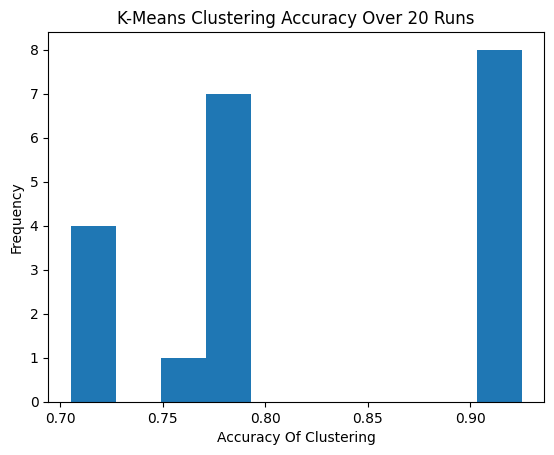

In [261]:
%matplotlib inline
accuracies = []
# Workspace I.8
# BEGIN 
# code here
X, labels = multi_blobs.X, multi_blobs.labels
for i in range(0,20):
    k_means = KMeans(5)
    k_means.fit(X)
    evaluation = evaluate_clustering(k_means, X, labels)
    accuracies.append(evaluation)
plt.hist(accuracies)
plt.xlabel("Accuracy Of Clustering")
plt.ylabel("Frequency")
plt.title("K-Means Clustering Accuracy Over 20 Runs")
# END

### Question 4 : Is there any modification you can do to the K-Means to improve the performance ? If so explain. [4 point]

### Answer:

There are some small modifications that I could make to improve the performance of the algorithm. For instance, there may be built in Python methods that calculate some of the values faster than the manual algorithms that I wrote, at least in terms of time complexity. We could also adjust the tolerance for the objective calculation to have it run more times so that the clustering was more accurate. We could potentially chose the initial centroids differently so that it would take less loops to reassign the clusters to the correct centroids. It seems that the biggest problem that I have in terms of accuracy is the initial centroid calculation. So this is something that I could redo in the future to improve the performance. As well as some other things as previously mentioned.